In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import DistanceMetric
from scipy.spatial.distance import mahalanobis
import os
import sys
from PIL import Image
sys.path.append('../models')
import ResNet as resnet
import DenseNet as densenet
import EfficientNet as efficientnet
import MobileNetV2 as mobilenet
import ViT as vit

import seaborn as sns

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
##########################################
######### Configure Metric Setting ####### 
##########################################
batch_size = 64
weight_path = './weights/celebA_split/celebAHQ_split_resnet18_nothing.pt'
model_base = torch.load(weight_path)
weight_path = './weights/celebA_split/celebAHQ_split_resnet18_v3.pt'
model_private = torch.load(weight_path)
criterion = nn.CrossEntropyLoss()
dataset_path = "/media/data2/data/CelebAMask-HQ/CelebA-HQ-img/"
annotation_path = "/media/data2/data/CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt"
data = 'CelebA'
##########################################
##########################################

In [4]:
class CelebA(Dataset):
    def __init__(self, root, annotation_path, transform=None):
        self.transform = transform
        self.root_dir = root
        self.classes = [
            "Female, Not smiling, Young", "Female, Not smiling, Old", 
            "Female, Smiling, Young", "Female, Smiling, Old", 
            "Male, Not smiling, Young", "Male, Not smiling, Old", 
            "Male, Smiling, Young", "Male, Smiling, Old",
        ]
        
        self.image_paths = []
        self.image_labels = []

        anno_file = open(annotation_path, "r")
        num = int(anno_file.readline())
    
        line = anno_file.readline()
        attributes = list(line[:-1].split(' '))
        
        sex_index = attributes.index('Male') + 2
        smile_index = attributes.index('Smiling') + 2
        young_index = attributes.index('Young') + 2
        for _ in range(num):
            line = anno_file.readline()
            record = list(line[:-1].split(' '))
            self.image_paths.append(record[0])
            if record[sex_index] == "1":
                if record[smile_index] == "1":
                    if record[young_index] == "1":
                        self.image_labels.append(6)
                    else:
                        self.image_labels.append(7)
                else:
                    if record[young_index] == "1":
                        self.image_labels.append(4)
                    else:
                        self.image_labels.append(5)
            else:
                if record[smile_index] == "1":
                    if record[young_index] == "1":
                        self.image_labels.append(2)
                    else:
                        self.image_labels.append(3)
                else:
                    if record[young_index] == "1":
                        self.image_labels.append(0)
                    else:
                        self.image_labels.append(1)
        anno_file.close()
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_file_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(image_file_path)

        label = self.image_labels[index]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [5]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) 
if data == 'Cifar-10':
    mean, std = (0.491, 0.482, 0.447), (0.247, 0.243, 0.262)
elif data == 'CelebA':
    mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

model_base.to(device)
model_base.eval()
model_private.to(device)
model_private.eval()

dataset =  CelebA(root=dataset_path, annotation_path=annotation_path, transform=trans)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False, )

classes = dataset.classes

In [6]:
latent_vectors_base = [[] for _ in range(8)]
latent_vectors_private = [[] for _ in range(8)]

with torch.no_grad():
    for data in dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        labels = labels.cpu().numpy().tolist()
        
        features, _ = model_base(images)
        features = features.cpu().numpy().tolist()
        for i in range(len(labels)):
            latent_vectors_base[labels[i]].append(features[i])
        
        features, _ = model_private(images)
        features = features.cpu().numpy().tolist()
        for i in range(len(labels)):
            latent_vectors_private[labels[i]].append(features[i])

#####################################
### Calculating Cosine Similarity ###
#####################################


/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



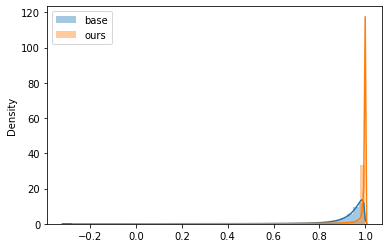

In [16]:
print("#####################################")
print("### Calculating Cosine Similarity ###")
print("#####################################")

cssm_base = np.array([])
cssm_private = np.array([])
for i in range(len(latent_vectors_base)):
    temp = cosine_similarity(np.array(latent_vectors_base[i])).reshape(-1)
    cssm_base = np.concatenate((cssm_base, temp))
    # print(f"max: {np.max(cssm_base):.4f}, min: {np.min(cssm_base):.4f}, mean: {np.mean(cssm_base):.4f}, var: {np.var(cssm_base):.4f}")
    
    temp = cosine_similarity(np.array(latent_vectors_private[i])).reshape(-1)
    cssm_private = np.concatenate((cssm_private, temp))
    # print(f"max: {np.max(cssm_private):.4f}, min: {np.min(cssm_private):.4f}, mean: {np.mean(cssm_private):.4f}, var: {np.var(cssm_private):.4f}")



sns.distplot(cssm_base, label="base")
sns.distplot(cssm_private, label="ours")
plt.legend()
plt.show()

#####################################
## Calculating Euclidean Distance ###
#####################################


/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



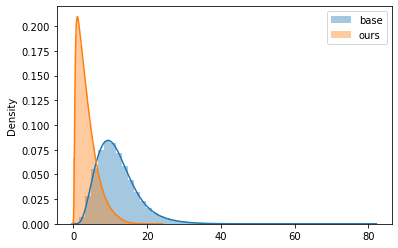

In [13]:
print("#####################################")
print("## Calculating Euclidean Distance ###")
print("#####################################")
dist = DistanceMetric.get_metric('euclidean')

euclidean_base = np.array([])
euclidean_private = np.array([])
for i in range(len(latent_vectors_base)):
    temp = dist.pairwise(np.array(latent_vectors_base[i])).reshape(-1)
    euclidean_base = np.concatenate((euclidean_base, temp))
    # print(f"max: {np.max(euclidean_base):.4f}, min: {np.min(euclidean_base):.4f}, mean: {np.mean(euclidean_base):.4f}, var: {np.var(euclidean_base):.4f}")
    
    temp = dist.pairwise(np.array(latent_vectors_private[i])).reshape(-1)
    euclidean_private = np.concatenate((euclidean_private, temp))
    # print(f"max: {np.max(euclidean_private):.4f}, min: {np.min(euclidean_private):.4f}, mean: {np.mean(euclidean_private):.4f}, var: {np.var(euclidean_private):.4f}")

sns.distplot(euclidean_base, label="base")
sns.distplot(euclidean_private, label="ours")
plt.legend()
plt.show()

#####################################
## Calculating Manhattan Distance ###
#####################################


/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



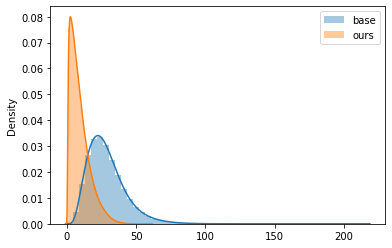

In [14]:
print("#####################################")
print("## Calculating Manhattan Distance ###")
print("#####################################")
dist = DistanceMetric.get_metric('manhattan')

manhattan_base = np.array([])
manhattan_private = np.array([])
for i in range(len(latent_vectors_base)):
    temp = dist.pairwise(np.array(latent_vectors_base[i])).reshape(-1)
    manhattan_base = np.concatenate((manhattan_base, temp))
    # print(f"max: {np.max(manhattan_base):.4f}, min: {np.min(manhattan_base):.4f}, mean: {np.mean(manhattan_base):.4f}, var: {np.var(manhattan_base):.4f}")
    
    temp = dist.pairwise(np.array(latent_vectors_private[i])).reshape(-1)
    manhattan_private = np.concatenate((manhattan_private, temp))
    # print(f"max: {np.max(manhattan_private):.4f}, min: {np.min(manhattan_private):.4f}, mean: {np.mean(manhattan_private):.4f}, var: {np.var(manhattan_private):.4f}")

sns.distplot(manhattan_base, label="base")
sns.distplot(manhattan_private, label="ours")
plt.legend()
plt.show()

#####################################
## Calculating Chebyshev Distance ###
#####################################


/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



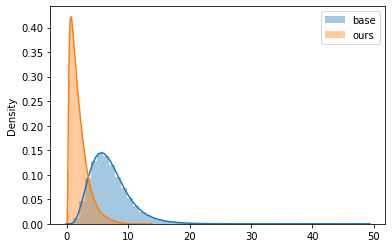

In [15]:
print("#####################################")
print("## Calculating Chebyshev Distance ###")
print("#####################################")
dist = DistanceMetric.get_metric('chebyshev')

chebyshev_base = np.array([])
chebyshev_private = np.array([])
for i in range(len(latent_vectors_base)):
    temp = dist.pairwise(np.array(latent_vectors_base[i])).reshape(-1)
    chebyshev_base = np.concatenate((chebyshev_base, temp))
    # print(f"max: {np.max(chebyshev_base):.4f}, min: {np.min(chebyshev_base):.4f}, mean: {np.mean(chebyshev_base):.4f}, var: {np.var(chebyshev_base):.4f}")
    
    temp = dist.pairwise(np.array(latent_vectors_private[i])).reshape(-1)
    chebyshev_private = np.concatenate((chebyshev_private, temp))
    # print(f"max: {np.max(chebyshev_private):.4f}, min: {np.min(chebyshev_private):.4f}, mean: {np.mean(chebyshev_private):.4f}, var: {np.var(chebyshev_private):.4f}")

sns.distplot(chebyshev_base, label="base")
sns.distplot(chebyshev_private, label="ours")
plt.legend()
plt.show()